In [1]:
import itertools
import sys, os

import numpy as np
import pandas as pd
from scipy.special import comb
from scipy import stats
import scipy.cluster.hierarchy as hac
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import statsmodels.api as sm

sns.set(rc={'figure.figsize':(15,8)})
sns.set_context('poster')
from sklearn.model_selection import train_test_split

In [2]:
%load_ext autoreload
%autoreload 2
import CCPA_lib as cp


In [3]:
sns.set(rc={'figure.figsize':(15,8)})
sns.set_context('talk')
sns.set_style('white')

In [4]:

ppallete = 'RdYlGn'#'YlGn_d' #"BuGn_d"
porder = ['MED4',  'MIT9312','MIT0604', 'Natl2A', 'MIT9313']
ppallete = [ '#62A586', '#face6e','#f79934', '#7A9BC8', '#F47681', ]
psizes = [150,120,200,120,350]
pmarkers = ['o', 's', '^', 'D', '*']

# #ffd7a1
    
pedge = 'green'
apallete = "spring"
aorder = ['DE', 'DE1', '1A3', 'ATCC', 'BS11']
amarkers = ['P', 'X', 'h', '<','>']
apallete = ['#6dad36', '#c7e89f', '#f5c4e1', '#d5579d', '#8a0850']

aedge='orange'
epallete = ['#6cf0ba', '#d13f75', '#eeb7cb', '#b9d2d8', '#407f90']
#sns.diverging_palette(355, 217, s=74, l=50, n=4) #'Paired' # 'BrBG'# "coolwarm"
eorder = ['e1','e3', 'e4', 'e5', 'e6']
#aedge='orange'


In [5]:
from sympy import *

In [253]:
df = pd.read_pickle('CCPA.pkl.gz')
df.loc[df.PRO == 'C9B', 'PRO'] = 'MIT0604'

In [6]:
import model.basic_model_lib

In [202]:
m = model.basic_model_lib.ModelProALT()

In [228]:
# Wall time: 8.66 s - 1 day
# Wall time: 40 s - 5 day
# Wall time: 2min 36s - 20 days
# Wall time: 13min 18s - 100 days
#%prun -s cumulative res = m.simulate(num_iterations=3*3600*24, collect_every=3600*6)
%time res = m.simulate(num_iterations=300*3600*24, collect_every=3600*6)

before: B_N^P + Delta_t*(-B_N_excretion^P - B_N_mortality^P + B_N_uptake^P)
after 0.999998726851852*B_N_P + 2.74884259259259e-5*N*X_P*(-B_N_P/X_P + 1.5e-9)/(N + 0.110088851603138)
before: B_C^P + Delta_t*(-B_C_excretion^P - B_C_mortality^P - B_C_respiration^P + B_C_uptake^P)
after -1.15740740740741e-5*B_C_P*(0.1886 - 0.0086*Max(3.0e-11*X_P/B_C_P, 7.0e-10*X_P/B_N_P)) + 0.999998726851852*B_C_P + 1.55096470004343e-5*C*X_P*(-B_C_P/X_P + 6.0e-9)/(C + 0.110088851603138)
before: B_N^A + Delta_t*(-B_N_excretion^A - B_N_mortality^A + B_N_uptake^A)
after 0.999998726851852*B_N_A + 2.74884259259259e-5*N*X_A*(-B_N_A/X_A + 1.5e-9)/(N + 0.110088851603138)
before: B_C^A + Delta_t*(-B_C_excretion^A - B_C_mortality^A - B_C_respiration^A + B_C_uptake^A)
after -1.15740740740741e-5*B_C_A*(0.1886 - 0.0086*Max(3.0e-11*X_A/B_C_A, 7.0e-10*X_A/B_N_A)) + 0.999998726851852*B_C_A + 1.55096470004343e-5*OC*X_A*(-B_C_A/X_A + 6.0e-9)/(OC + 0.110088851603138)
before: Delta_t*X^P*(-mortality^P + mu^P) + X^P
after 1.1574

In [229]:
res_df = pd.DataFrame(res)

In [230]:
res_df['q_n_p'] = res_df['b_n_p'] / res_df['x_p']
res_df['q_c_p'] = res_df['b_c_p'] / res_df['x_p']
res_df['q_n_a'] = res_df['b_n_a'] / res_df['x_a']
res_df['q_c_a'] = res_df['b_c_a'] / res_df['x_a']


In [231]:
res_df['qratio_n_p'] = m.get_param_val('q_n_min_p') / res_df['q_n_p']
res_df['qratio_c_p'] = m.get_param_val('q_c_min_p') / res_df['q_c_p']
res_df['qratio_n_a'] = m.get_param_val('q_n_min_a') / res_df['q_n_a']
res_df['qratio_c_a'] = m.get_param_val('q_c_min_a') / res_df['q_c_a']


In [232]:
res_df['maxqratio_p'] = res_df[['qratio_n_p' , 'qratio_c_p']].max(axis=1)
res_df['maxqratio_a'] = res_df[['qratio_n_a' , 'qratio_c_a']].max(axis=1)


In [233]:
res_df['mu_p'] = m.get_param_val('q_c_min_p') * (1 - res_df['maxqratio_p'])
res_df['mu_a'] = m.get_param_val('q_c_min_a') * (1 - res_df['maxqratio_a'])


In [234]:
#x1 = x +(x * mu*delta_t)
#x1 -x = x * mu*delta_t
#(x1 -x)/(x*t) =  mu

res_df['act_mu_p'] = (res_df['x_p'] - res_df['x_p'].shift())/(res_df['x_p'].shift()*4)
res_df['act_mu_a'] = (res_df['x_a'] - res_df['x_a'].shift())/(res_df['x_a'].shift()*4)



In [235]:
res_df['n_ratio'] = res_df['n']/ (res_df['n'] + m.get_param_val('k_n_p'))

In [236]:
res_df.describe().T

,count,mean,std,min,25%,50%,75%,max
b_n_p,1200.0,1.234559e-04,4.767300e-04,6.153657e-17,1.733516e-13,4.883188e-10,1.375498e-06,3.874337e-03
b_c_p,1200.0,9.369595e-04,3.618108e-03,4.670273e-16,1.315639e-12,3.706061e-09,1.043925e-05,2.940401e-02
b_n_a,1200.0,1.234559e-03,4.767300e-03,6.153657e-16,1.733516e-12,4.883188e-09,1.375498e-05,3.874337e-02
b_c_a,1200.0,1.128863e-03,4.358573e-03,5.629147e-16,1.585759e-12,4.466967e-09,1.258257e-05,3.541414e-02
x_p,1200.0,1.775960e+05,6.857944e+05,8.852270e-08,2.493729e-04,7.024653e-01,1.978707e+03,5.573382e+06
x_a,1200.0,1.775960e+06,6.857944e+06,8.852270e-07,2.493729e-03,7.024653e+00,1.978707e+04,5.573382e+07
n,1200.0,1.603746e-04,2.711636e-20,1.603746e-04,1.603746e-04,1.603746e-04,1.603746e-04,1.603746e-04
c,1200.0,3.132496e+03,7.976547e-03,3.132434e+03,3.132498e+03,3.132499e+03,3.132499e+03,3.132499e+03
on,1200.0,1.122870e+02,4.839259e-03,1.122489e+02,1.122882e+02,1.122883e+02,1.122883e+02,1.122883e+02
oc,1200.0,1.821010e-03,1.158299e-07,1.820157e-03,1.821041e-03,1.821042e-03,1.821042e-03,1.821042e-03


In [237]:
res_df.columns

Index(['b_n_p', 'b_c_p', 'b_n_a', 'b_c_a', 'x_p', 'x_a', 'n', 'c', 'on', 'oc',
       'day', 'q_n_p', 'q_c_p', 'q_n_a', 'q_c_a', 'qratio_n_p', 'qratio_c_p',
       'qratio_n_a', 'qratio_c_a', 'maxqratio_p', 'maxqratio_a', 'mu_p',
       'mu_a', 'act_mu_p', 'act_mu_a', 'n_ratio'],
      dtype='object')

In [238]:
m.get_param_val('q_n_max_p'), m.get_param_val('q_n_min_p'), 

(1.5e-09, 7e-10)

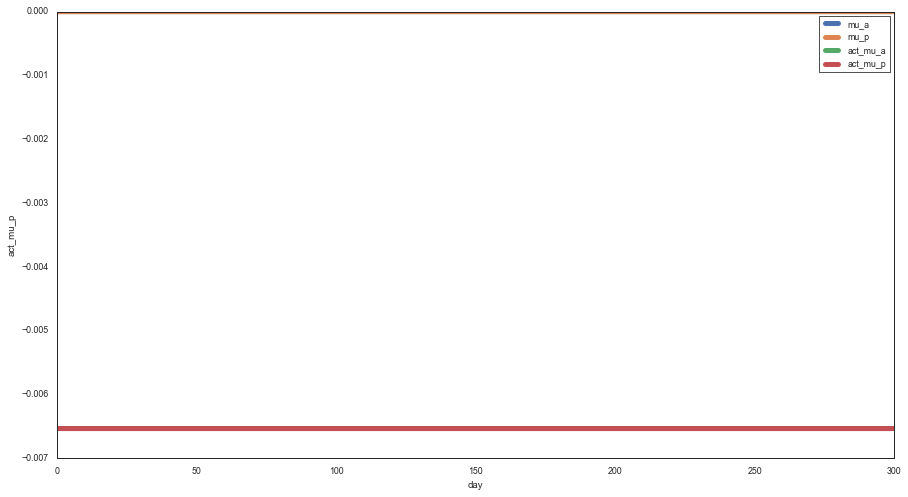

In [239]:
#sns.set_context('paper')
for i in [
     'mu_a',
    'mu_p',
   'act_mu_a',
    'act_mu_p'
       ]:
    sns.lineplot(data=res_df, x='day', y=i, label=i, lw=5)
    #plt.ylim(0, 2e-11)
    
    #plt.show()    

for i in [
  #   'mu_inf_p', 'mu_inf_a', 
       ]:
    sns.lineplot(data=res_df, x='day', y=m.get_param_val(i), label=i)
plt.legend(bbox_to_anchor=(1,1))
#plt.ylim(0, 1e-10)
plt.show()

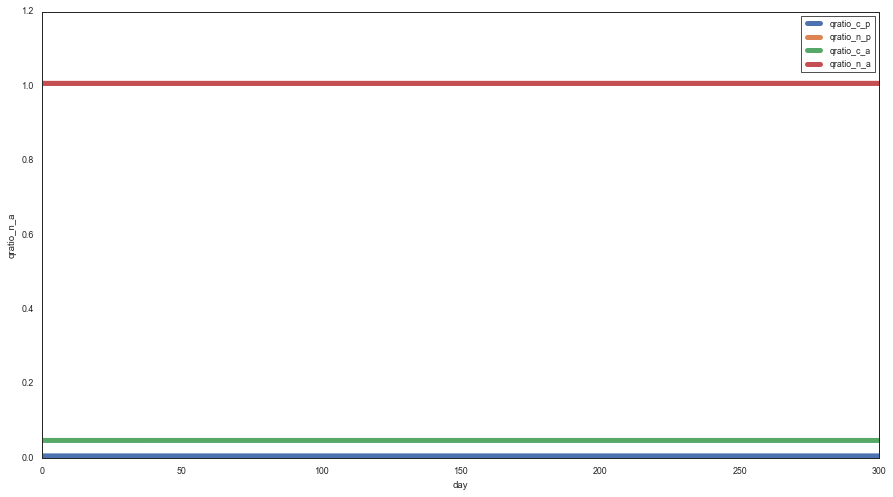

In [240]:
#sns.set_context('paper')
for i in [
     'qratio_c_p',
     'qratio_n_p',
     'qratio_c_a',
     'qratio_n_a',
       ]:
    sns.lineplot(data=res_df, x='day', y=i, label=i, lw=5)
    #plt.ylim(0, 2e-11)
    
    #plt.show()    

for i in [
  #   'mu_inf_p', 'mu_inf_a', 
       ]:
    sns.lineplot(data=res_df, x='day', y=m.get_param_val(i), label=i)
plt.legend(bbox_to_anchor=(1,1))
#plt.ylim(0, 1e-10)
plt.show()

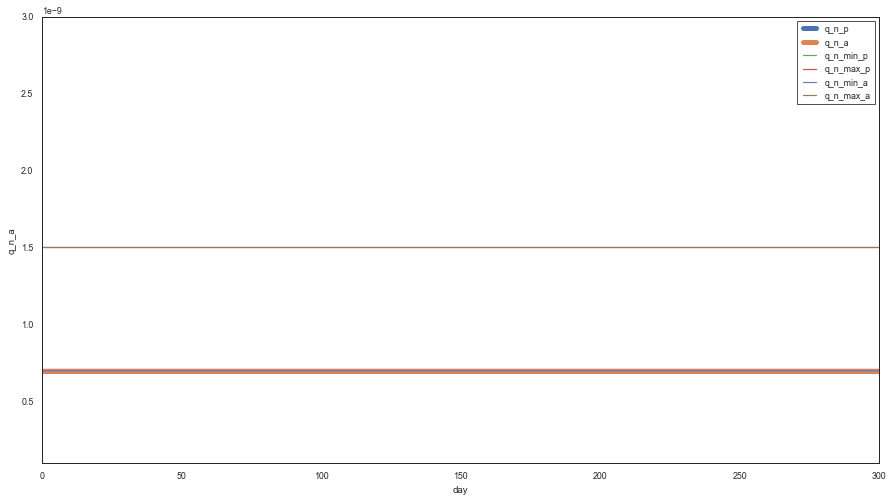

In [241]:
#sns.set_context('paper')
for i in [
     'q_n_p', 'q_n_a', 
       ]:
    sns.lineplot(data=res_df, x='day', y=i, label=i, lw=5)

for i in [
     'q_n_min_p', 'q_n_max_p', 
     'q_n_min_a', 'q_n_max_a', 
       ]:
    sns.lineplot(data=res_df, x='day', y=m.get_param_val(i), label=i)
plt.legend(bbox_to_anchor=(1,1))
plt.ylim(1e-10, 3e-9)
plt.show()

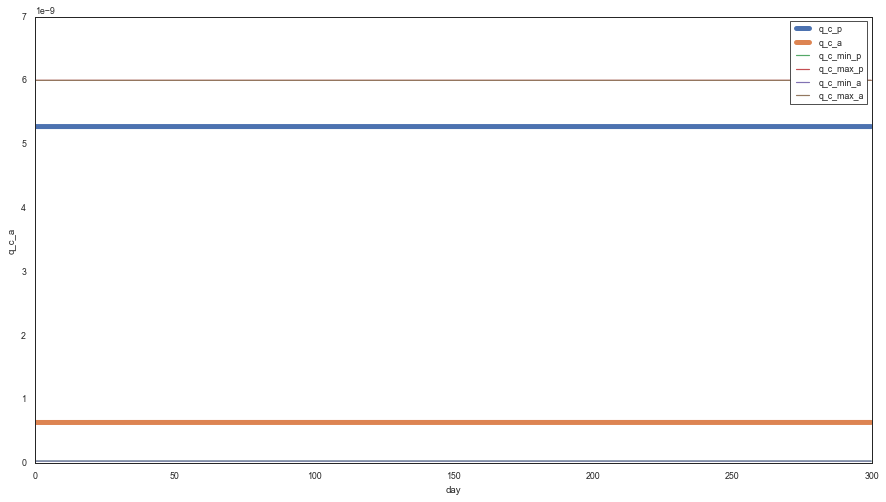

In [242]:
#sns.set_context('paper')
for i in [
     'q_c_p', 'q_c_a', 
       ]:
    sns.lineplot(data=res_df, x='day', y=i, label=i, lw=5)

for i in [
     'q_c_min_p', 'q_c_max_p', 
     'q_c_min_a', 'q_c_max_a', 
       ]:
    sns.lineplot(data=res_df, x='day', y=m.get_param_val(i), label=i)
plt.legend(bbox_to_anchor=(1,1))
plt.ylim(0, 7e-9)
plt.show()

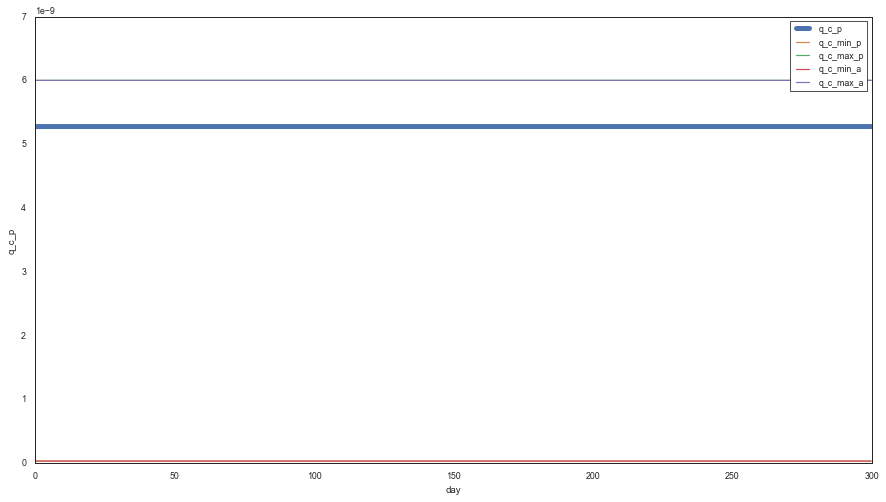

In [243]:
#sns.set_context('paper')
for i in [
     'q_c_p', #'q_c_a', 
       ]:
    sns.lineplot(data=res_df, x='day', y=i, label=i, lw=5)

for i in [
     'q_c_min_p', 'q_c_max_p', 
     'q_c_min_a', 'q_c_max_a', 
       ]:
    sns.lineplot(data=res_df, x='day', y=m.get_param_val(i), label=i)
plt.legend(bbox_to_anchor=(1,1))
plt.ylim(0, 7e-9)
plt.show()

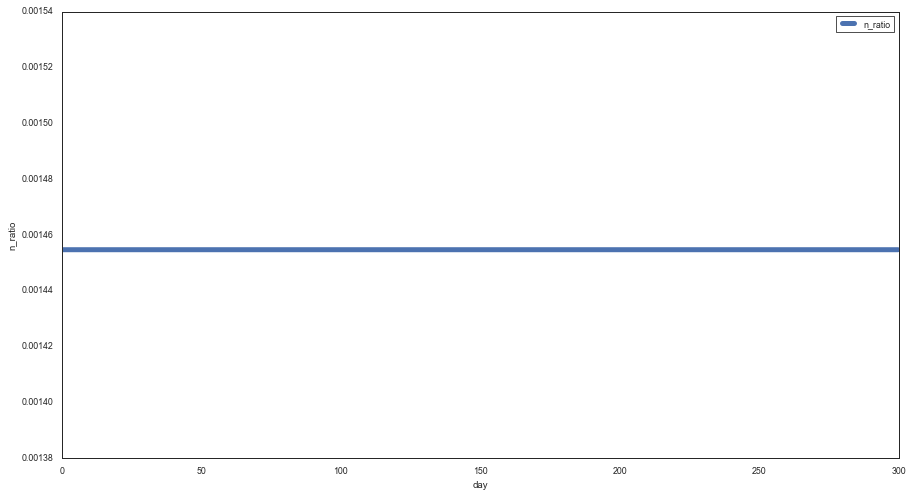

In [244]:
sns.set_context('paper')
for i in [
    'n_ratio'
       ]:
    ax = sns.lineplot(data=res_df, x='day', y=i, label=i, lw=5)
    ax.ticklabel_format(style='plain', useOffset=False)
plt.legend(bbox_to_anchor=(1,1))
#plt.yscale('log')
#plt.ylim(0,200)
plt.show()

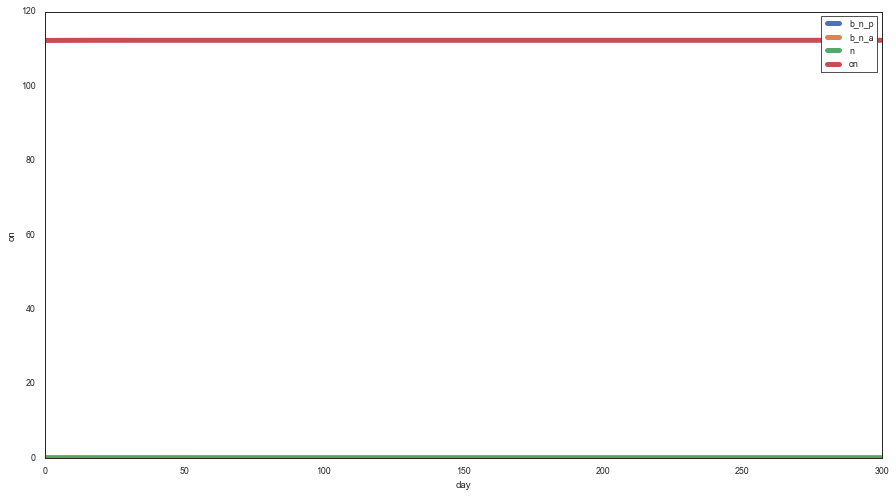

In [245]:
sns.set_context('paper')
for i in [
    'b_n_p', 'b_n_a',  'n', 'on',
       #'delta_b_n_p_uptake', 'delta_b_n_p_mortality', 'delta_b_n_p_excretion',
       #'delta_b_n_a_uptake', 'delta_b_n_a_mortality', 'delta_b_n_a_excretion',
       ]:
    sns.lineplot(data=res_df, x='day', y=i, label=i, lw=5)
plt.legend(bbox_to_anchor=(1,1))
#plt.yscale('log')
#plt.ylim(0,200)
plt.show()

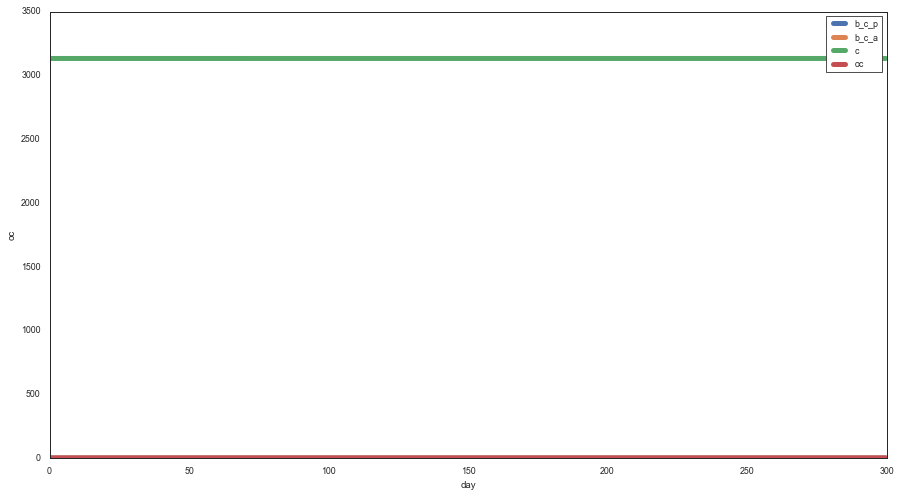

In [246]:
sns.set_context('paper')
for i in [
    'b_c_p', 'b_c_a',  'c', 'oc',
       #'delta_b_n_p_uptake', 'delta_b_n_p_mortality', 'delta_b_n_p_excretion',
       #'delta_b_n_a_uptake', 'delta_b_n_a_mortality', 'delta_b_n_a_excretion',
       ]:
    sns.lineplot(data=res_df, x='day', y=i, label=i, lw=5)
plt.legend(bbox_to_anchor=(1,1))
#plt.yscale('log')
#plt.ylim(0,200)
plt.show()

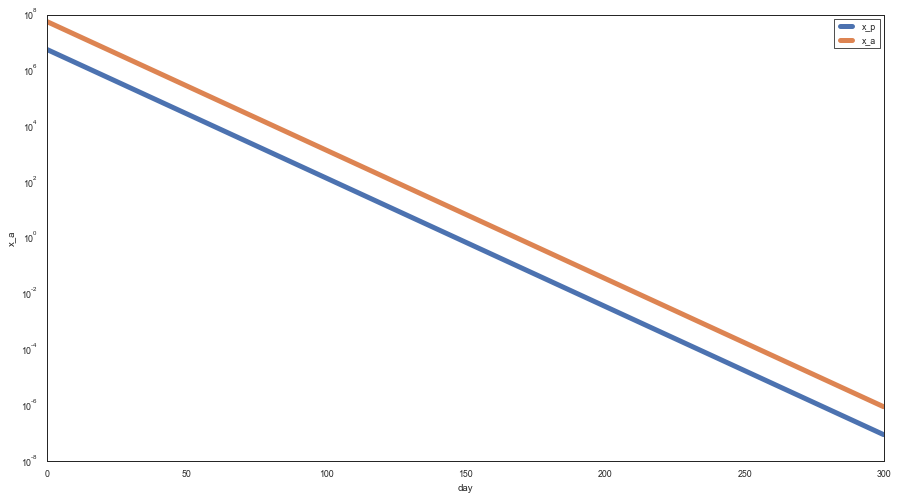

In [247]:
sns.set_context('paper')
for i in [
    'x_p', 'x_a',#  'c', 'oc',
       #'delta_b_n_p_uptake', 'delta_b_n_p_mortality', 'delta_b_n_p_excretion',
       #'delta_b_n_a_uptake', 'delta_b_n_a_mortality', 'delta_b_n_a_excretion',
       ]:
    sns.lineplot(data=res_df, x='day', y=i, label=i, lw=5)
plt.legend(bbox_to_anchor=(1,1))
plt.yscale('log')
#plt.ylim(0,200)
plt.show()

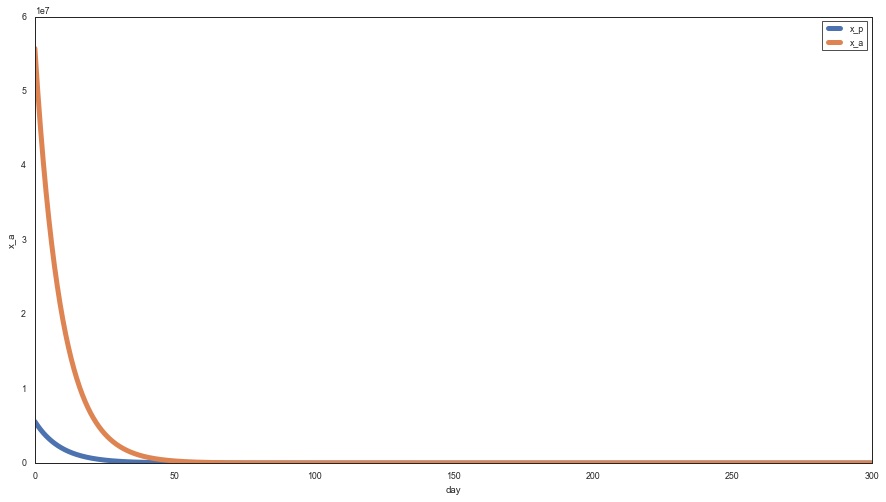

In [248]:
sns.set_context('paper')
for i in [
    'x_p', 'x_a',#  'c', 'oc',
       #'delta_b_n_p_uptake', 'delta_b_n_p_mortality', 'delta_b_n_p_excretion',
       #'delta_b_n_a_uptake', 'delta_b_n_a_mortality', 'delta_b_n_a_excretion',
       ]:
    sns.lineplot(data=res_df, x='day', y=i, label=i, lw=5)
plt.legend(bbox_to_anchor=(1,1))
#plt.yscale('log')
#plt.ylim(0,200)
plt.show()

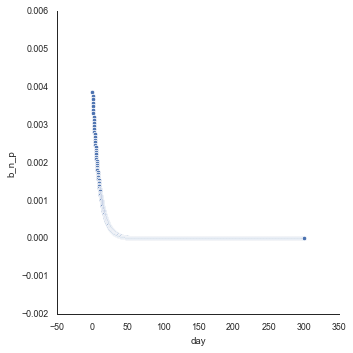

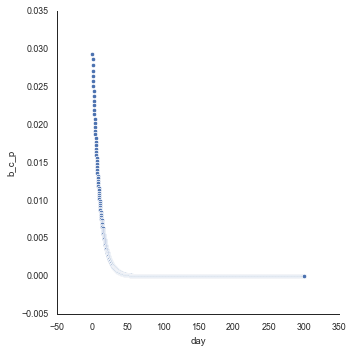

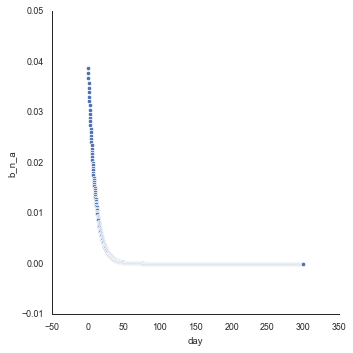

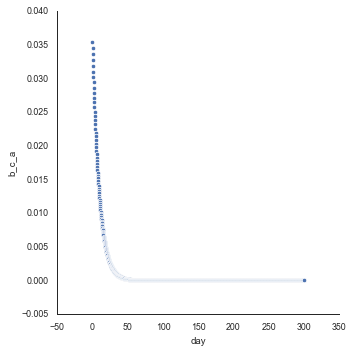

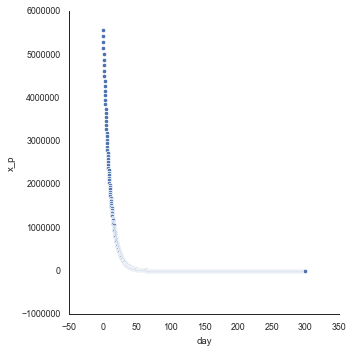

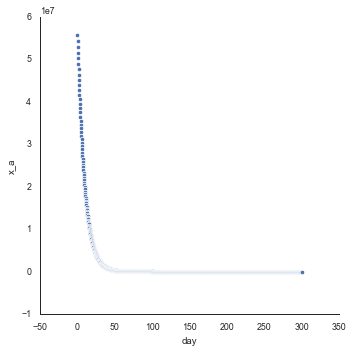

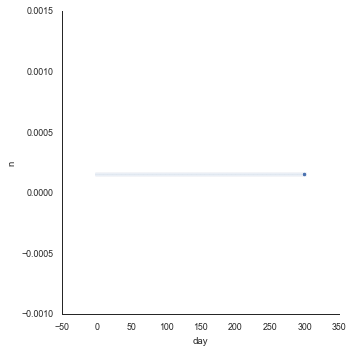

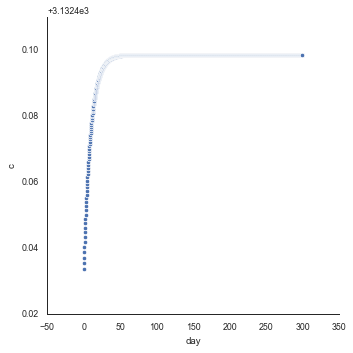

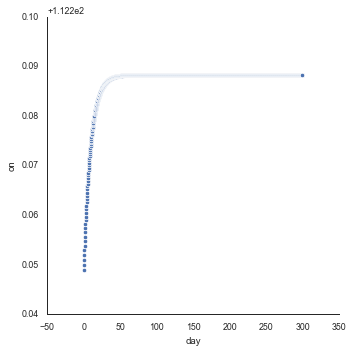

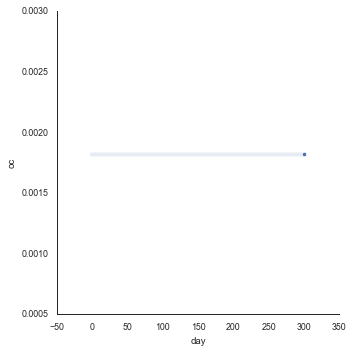

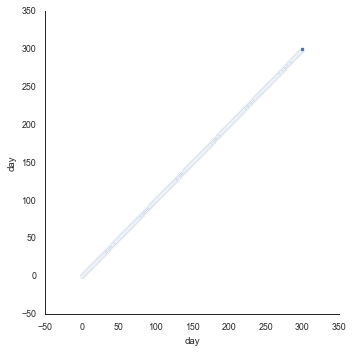

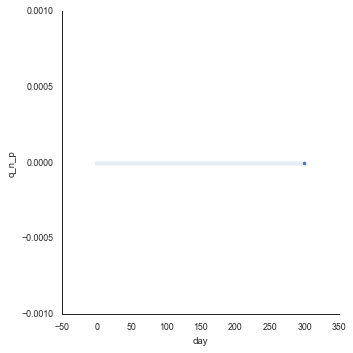

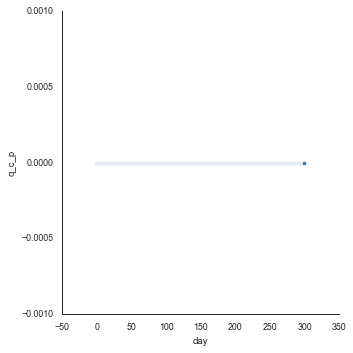

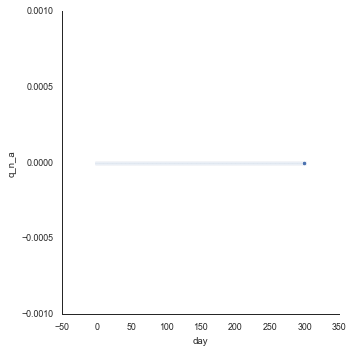

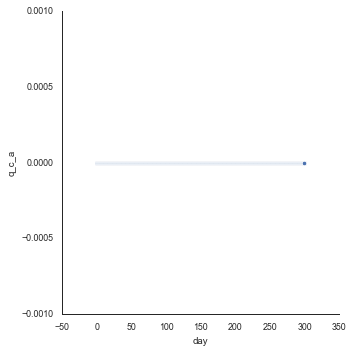

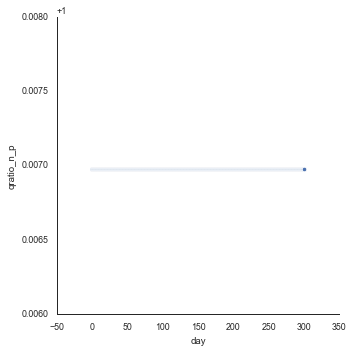

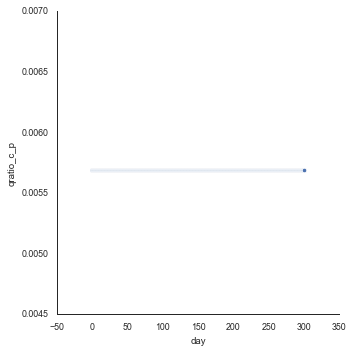

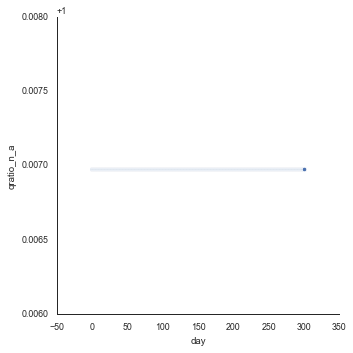

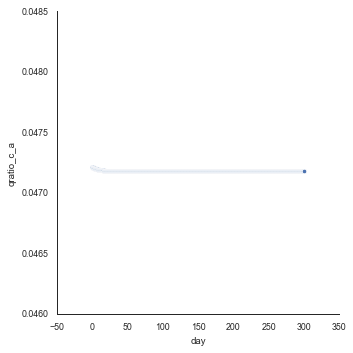

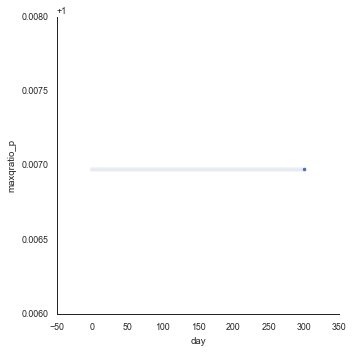

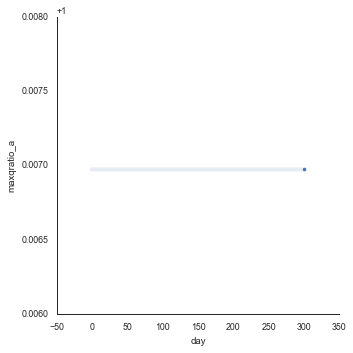

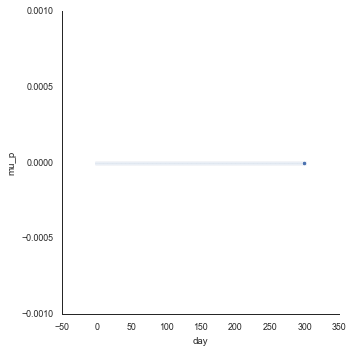

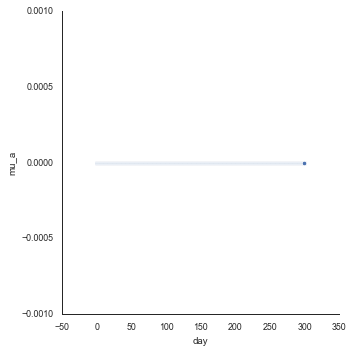

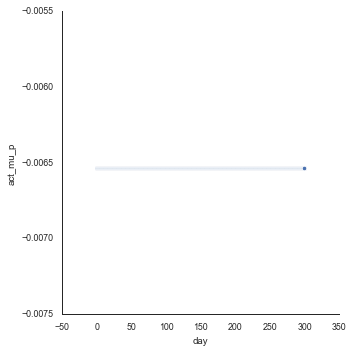

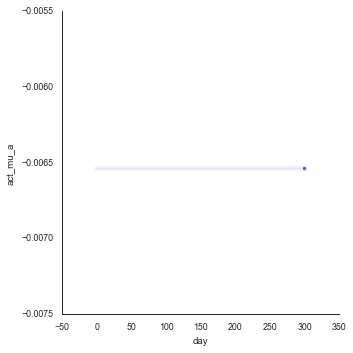

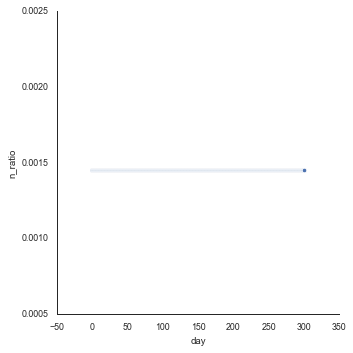

In [249]:
for i in res_df.columns:
    sns.relplot(data=res_df, x='day', y=i)

In [250]:
res_df.loc[res_df.oc <0].head()

,b_n_p,b_c_p,b_n_a,b_c_a,x_p,x_a,n,c,on,oc,...,qratio_c_p,qratio_n_a,qratio_c_a,maxqratio_p,maxqratio_a,mu_p,mu_a,act_mu_p,act_mu_a,n_ratio


In [251]:
res_df.loc[res_df.n <0].head()

,b_n_p,b_c_p,b_n_a,b_c_a,x_p,x_a,n,c,on,oc,...,qratio_c_p,qratio_n_a,qratio_c_a,maxqratio_p,maxqratio_a,mu_p,mu_a,act_mu_p,act_mu_a,n_ratio


In [252]:
res_df.tail()

,b_n_p,b_c_p,b_n_a,b_c_a,x_p,x_a,n,c,on,oc,...,qratio_c_p,qratio_n_a,qratio_c_a,maxqratio_p,maxqratio_a,mu_p,mu_a,act_mu_p,act_mu_a,n_ratio
1195,6.841771e-17,5.192513e-16,6.841771e-16,6.258609e-16,9.842148e-08,9.842148e-07,0.00016,3132.498509,112.288261,0.001821,...,0.005686,1.006977,0.047177,1.006977,1.006977,-2.093023e-13,-2.093023e-13,-0.006538,-0.006538,0.001455
1196,6.662845e-17,5.056718e-16,6.662845e-16,6.094934e-16,9.584757e-08,9.584757e-07,0.00016,3132.498509,112.288261,0.001821,...,0.005686,1.006977,0.047177,1.006977,1.006977,-2.093023e-13,-2.093023e-13,-0.006538,-0.006538,0.001455
1197,6.488598e-17,4.924475e-16,6.488598e-16,5.935539e-16,9.334096e-08,9.334096e-07,0.00016,3132.498509,112.288261,0.001821,...,0.005686,1.006977,0.047177,1.006977,1.006977,-2.093023e-13,-2.093023e-13,-0.006538,-0.006538,0.001455
1198,6.318909e-17,4.795690e-16,6.318909e-16,5.780313e-16,9.089991e-08,9.089991e-07,0.00016,3132.498509,112.288261,0.001821,...,0.005686,1.006977,0.047177,1.006977,1.006977,-2.093023e-13,-2.093023e-13,-0.006538,-0.006538,0.001455
1199,6.153657e-17,4.670273e-16,6.153657e-16,5.629147e-16,8.852270e-08,8.852270e-07,0.00016,3132.498509,112.288261,0.001821,...,0.005686,1.006977,0.047177,1.006977,1.006977,-2.093023e-13,-2.093023e-13,-0.006538,-0.006538,0.001455
